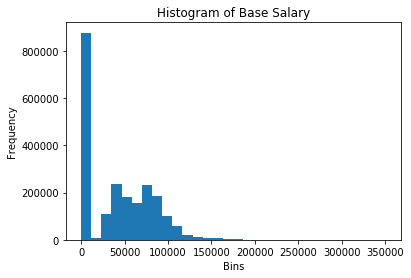


The correlation between base salary and agency is:  0.776036539578

The correlation between work borough and base salary is:  -0.298956900573

The correlation between the number of employment years and base salary is:  0.356968461703

The number of outliers for column "Base Salary" is: 1761.

The number of outliers for column "Regular Gross Paid" is: 4291.

The number of outliers for column "Total OT Paid" is: 507691.

The number of outliers for column "Total Other Pay" is: 430171.

For the outliers, we could either drop them or analyze them seperately.

The average salary of "District Attorney" is 67343.23562168454.

The average salary of "Comptroller" is 71956.48884993362.

The average salary of "Police Officer" is 69567.72724394212.

The average salary of "Teacher" is 38721.27503723877.

The average salary of "Manhattan" is 36326.08590888384.

The average salary of "Brooklyn" is 49329.631117027115.

Predict salary based on agency:


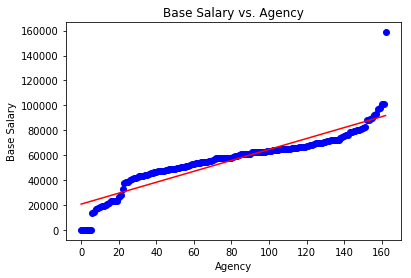


Coefficients:  [ 438.68688392]
Mean squared error: 77392159.13
Variance score: 0.85


In [2]:
# -*- coding: utf-8 -*-
"""
homework for EDA 3

•            Discretize salary field

              * With defined bins

              * Based on quantiles

•            Feature correlation

              * Correlation between base salary and agency

              * Correlation between work borough and base salary

              * Correlation between the number of employment years and base salary

•            Outlier detection and filtering

              * Is there any outlier in each field of the data?

              * How would you deal with the outliers?

              * Find out employees whose salary is at the bottom 5% and/or top 5%

•            Hypothesis testing

              * District Attorney earns same amount of salary on average as CompController?

              * Police officers earn same amount of salary on average as teachers?

              * Employees in Manhattan earn same amount of salary on average as those in Brooklyn

Regression model (bonus points)

•            Choose a sub-set of features for predicting an employee’s salary

•            Use the subset of features to build a regression model (http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html)

•            Evaluate the performance of the model (Mean Squared Error)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data into a dataframe
payroll_df = pd.read_csv('Citywide_Payroll_Data__Fiscal_Year_.csv',dtype='str')

# Clean up columns as needed

# Remove leading and trailing whitespaces of a string
for col in payroll_df.columns:
    payroll_df[col] = payroll_df[col].str.strip() 
    
# Drop the records without first name and last name, as well as the duplicated records
payroll_df = payroll_df.dropna(axis=0, how='all', subset=['First Name','Last Name']).drop_duplicates()
    
# Convert the 'Fiscal Year' field from string to int
payroll_df['Fiscal Year'] = payroll_df['Fiscal Year'].astype('int64')

# Convert the fields 'Regular Hours','OT Hours' from string to float
payroll_df[['Regular Hours','OT Hours']] = payroll_df[['Regular Hours','OT Hours']].astype('float64')

# Convert all monetary columns to numeric data type 
for col in ['Base Salary','Regular Gross Paid','Total OT Paid','Total Other Pay']:
    payroll_df[col] = payroll_df[col].str.replace('$','').astype('float64')

# Convert the fields 'Agency Name','Title Description','Work Location Borough'to lower case
for col in ['Agency Name','Title Description','Work Location Borough']:
    payroll_df[col] = payroll_df[col].str.lower()
    
# Convert "9999" to "1999" in 'Agency Start Date' field
payroll_df['Agency Start Date'] = payroll_df['Agency Start Date'].str.replace('9999', '1999')
    
# Convert the 'Agency Start Date' field from string to datetime
payroll_df['Agency Start Date'] = pd.to_datetime(payroll_df['Agency Start Date'],format='%m/%d/%Y')




# Discretize salary field with defined bins
n, bins, patches = plt.hist(payroll_df['Base Salary'],30)

plt.xlabel('Bins')
plt.ylabel('Frequency')
plt.title('Histogram of Base Salary')
plt.show()

payroll_df['bins'] = pd.cut(payroll_df['Base Salary'],bins)


# Discretize salary field based on quantiles
quantiles = pd.qcut(payroll_df['Base Salary'],30,duplicates='drop')
payroll_df = payroll_df.assign(quantile = quantiles.values)



# Feature correlation
# Correlation between base salary and agency
sort_agency = pd.DataFrame(payroll_df.groupby(['Agency Name'])['Base Salary'].mean().sort_values())
sort_agency['agency_rank'] = range(sort_agency.size)
payroll_df['agency_rank'] = payroll_df['Agency Name'].map(sort_agency['agency_rank'])

print('\nThe correlation between base salary and agency is: ', payroll_df['Base Salary'].corr(payroll_df['agency_rank']))

# Correlation between work borough and base salary
sort_loc = pd.DataFrame(payroll_df.groupby(['Work Location Borough'])['Base Salary'].mean().sort_values(ascending=False))
sort_loc['loc_rank'] = range(sort_loc.size)
payroll_df['loc_rank'] = payroll_df['Work Location Borough'].map(sort_loc['loc_rank'])

print('\nThe correlation between work borough and base salary is: ', payroll_df['loc_rank'].corr(payroll_df['Base Salary']))

# Correlation between the number of employment years and base salary
payroll_df['work_years'] = payroll_df['Fiscal Year'] - payroll_df['Agency Start Date'].dt.year
print('\nThe correlation between the number of employment years and base salary is: ', payroll_df['Base Salary'].corr(payroll_df['work_years'],method='spearman'))


# Outlier detection and filtering
# Use IQR method to get outliers, which is used for non Guassian Distribution
def salary_outlier(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr=q3-q1
    lower = q1-1.5*iqr
    upper = q3+1.5*iqr
    out_df = df[(df[col]<lower)|(df[col]>upper)]
    #print ('The lower threshold is: {}\nThe upper threshold is: {}'.format(lower, upper))
    print ('\nThe number of outliers for column "{}" is: {}.'.format(col, out_df.index.size))
    return out_df

# Is there any outlier in each field of the data?
salary_outlier(payroll_df,'Base Salary')
salary_outlier(payroll_df,'Regular Gross Paid')
salary_outlier(payroll_df,'Total OT Paid')
salary_outlier(payroll_df,'Total Other Pay')

# How would you deal with the outliers?
print("\nFor the outliers, we could either drop them or analyze them seperately.")

# Find out employees whose salary is at the bottom 5% and/or top 5%
payroll_df[(payroll_df['Base Salary']<=payroll_df['Base Salary'].quantile(0.05)) | (payroll_df['Base Salary']>=payroll_df['Base Salary'].quantile(0.95))]



# Hypothesis testing

# calculate average salary in payroll_df
def ave_pay(col,strr):
    strl=strr.lower()
    nonan_df = payroll_df.dropna(axis=0,subset=[col])
    average_pay = nonan_df['Base Salary'][(nonan_df[col].str.contains(strl))].mean()
    print ('\nThe average salary of "{}" is {}.'.format(strr,average_pay))
    return average_pay

# District Attorney earns same amount of salary on average as CompController?
ave_pay('Agency Name','District Attorney')
ave_pay('Agency Name','Comptroller')

# Police officers earn same amount of salary on average as teachers?
ave_pay('Title Description','Police Officer')
ave_pay('Title Description','Teacher')

# Employees in Manhattan earn same amount of salary on average as those in Brooklyn
ave_pay('Work Location Borough','Manhattan')
ave_pay('Work Location Borough','Brooklyn')


# Choose 'Agency Name' as subset to predict salary
# Use "agency_rank" as x-variables, "Base Salary" as y-variables
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

x=sort_agency[['agency_rank']].values
y=sort_agency['Base Salary']

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model
regr.fit(x,y)

# Obtain fitted y
y_fit = regr.predict(x)

print('\nPredict salary based on agency:')

# plot output
plt.scatter(x,y,color='blue')
plt.plot(x,y_fit,color='red')
plt.xlabel('Agency')
plt.ylabel('Base Salary')
plt.title('Base Salary vs. Agency')
plt.show()

# The coefficients
print('\nCoefficients: ', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y, y_fit))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y, y_fit))